# Basic Trading Strategies

The goal of this notebook is to create and run few basic trading strategies. We do ignore all trading costs and assume that we can always buy and sell at close prices.

In [1]:
import os
import sys

sys.path.insert(0, os.path.abspath('../src'))

In [2]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from tqdm.notebook import tqdm, trange
from IPython.display import display, HTML

import pytrade.data as pyd

In [3]:
pd.set_option('display.min_rows', 50)
np.random.seed(1234)

Let's start by loading some market data.

## Market Data

In [4]:
# Path to data location
DATA_DIR = '../data/price-volume-data-for-all-us-stocks-etfs/Data'
STOCK_DIR = 'Stocks'
ETF_DIR = 'ETFs'
equity_data = pyd.EquityData(DATA_DIR, STOCK_DIR, ETF_DIR)

Let's test out the EquityData class by retrieving market data for an example ticker.

In [5]:
example_ticker = 'AAPL'
equity_data.get_csv_data(example_ticker).head()

,date,ticker,price,volume,dayofweek
date,,,,,
1984-09-07,1984-09-07,aapl,0.42388,23220030,4
1984-09-10,1984-09-10,aapl,0.42134,18022532,0
1984-09-11,1984-09-11,aapl,0.42902,42498199,1
1984-09-12,1984-09-12,aapl,0.41618,37125801,2
1984-09-13,1984-09-13,aapl,0.43927,57822062,3


This works. The next step is to create and run some trading strategies. Let's start by defining an interface that all strategies will follow.

## Trading Strategies

In [6]:
from abc import ABC, abstractmethod


class Strategy(ABC):
    """
    Base class for all trading strategies.
    
    Attributes:
        ticker (str): A ticker for which the strategy will be executed.
        config (Dict): A strategy specific configuration.
        invested (bool): Keeps track of whether we are invested in (bought into) a particular stock.
        signals (List[List[str, Timestamp, str]]): Keeps track of buy and sell signals generated
            by the strategy.
    """

    BUY_SIGNAL = 'buy'

    SELL_SIGNAL = 'sell'

    def __init__(self, ticker, config=None):
        self.ticker = ticker.lower()
        self.config = config
        self.invested = False
        self.signals = []

    def buy_signal(self, date):
        """
        Generates a buy signal for the given date.
        
        Args:
            date (Timestamp): A date for which a signal is generated.
        """
        self.signals.append([self.ticker, date, self.BUY_SIGNAL])

    def sell_signal(self, date):
        """
        Generates a sell signal for the given date.
        
        Args:
            date (Timestamp): A date for which generate a sell signal.
        """
        self.signals.append([self.ticker, date, self.SELL_SIGNAL])

    def get_signals(self):
        """
        Returns all buy and sell signals that were generated.
            
        Returns:
            (pd.DataFrame): A table containing signals.
        """
        signals_df = pd.DataFrame(data=self.signals,
                                  columns=['ticker', 'date', 'signal'])
        signals_df.index = signals_df.date
        return signals_df

    def get_config(self):
        """
        Returns the strategy config.
            
        Returns:
            (Dict): The strategy config.
        """
        return self.config

    @abstractmethod
    def execute(self, data):
        """
        Performs an execution of a trading strategy.

        Args:
            data (pd.DataFrame): A table containing market data.
        """
        pass

    def plot(self, data):
        """
        Plots timeseries relevant to the given strategy.

        Args:
            data (pd.DataFrame): A table containing market data and any derived timeseries.
        """
        pass

We start with the simplest trading strategy: Buy and Hold Strategy. We buy shares when we start to trade and wait till the last day of trading.

In [7]:
class BuyAndHoldStrategy(Strategy):
    """
    Implementation of the buy and hold strategy.
    """
    def __init__(self, ticker, config=None):
        super().__init__(ticker)

    def execute(self, data):
        """
        Implementation of the buy and hold strategy. We generate a buy signal at the beginning of trading and
        only sell at the last day of trading.

        Args:
            data (pd.DataFrame): A table containing market data.
        """
        for _, data in data.iterrows():
            if not self.invested:
                self.buy_signal(data['date'])
                self.invested = True

A well-known strategy is to observe two simple moving averages and based on when and how they cross over generate buy or sell signals.

In [8]:
class SimpleMovingAvgCrossOverStrategy(Strategy):
    """
    Implementation of the Simple Moving Average Crossover strategy.
    """
    def __init__(self, ticker, config=None):
        if config is None:
            config = {}
            config['sma_short'] = 100
            config['sma_long'] = 300

        super().__init__(ticker, config)

    def execute(self, data):
        """
        Executes the Simple Moving Average Crossover strategy.
        
        As part of this strategy we keep track of two simple moving averages with different periods. 
        If the shorter period moving average crosses above the longer period moving average -- this is a buy
        signal. If it goes below the longer period moving average -- this is a sell signal.

        Args:
            data (pd.DataFrame): A table containing market data.
        """
        data['sma_short'] = data['price'].rolling(
            self.config['sma_short'],
            min_periods=self.config['sma_short']).mean()
        data['sma_long'] = data['price'].rolling(
            self.config['sma_long'],
            min_periods=self.config['sma_long']).mean()

        for _, data in data.iterrows():
            if data['sma_short'] > data['sma_long'] and not self.invested:
                self.buy_signal(data['date'])
                self.invested = True
            elif data['sma_short'] < data['sma_long'] and self.invested:
                self.sell_signal(data['date'])
                self.invested = False

    def plot(self, data):
        """
        Plots the two moving averages.
        
        Args:
            data (pd.DataFrame): A table containing market data and any derived timeseries.
        """
        plt.plot(data.date,
                 data['sma_short'],
                 label='{}-Day Moving Avg'.format(self.config['sma_short']),
                 color='darkorange',
                 zorder=0)
        plt.plot(data.date,
                 data['sma_long'],
                 label='{}-Day Moving Avg'.format(self.config['sma_long']),
                 color='brown',
                 zorder=0)

We also consider the so called Bollinger Band strategy. This strategy requires a calculation of a simple moving average as well as the corresponding rolling standard deviation. This allows to calculate bands that are x-times standard deviations away from the moving average. When a stock crosses above the upper band we use it as a buy signal and if it goes below the lower band than it is a sell signal.

In [9]:
class BollingerBandStrategy(Strategy):
    """
    Implementation of the Bollinger Band strategy.
    """
    def __init__(self, ticker, config={}):
        if config is None:
            config = {}
            config['sma'] = 20
            config['sd'] = 2

        super().__init__(ticker, config)

    def execute(self, data):
        """
        Executes the Bollinger Band strategy.
        
        As part of this strategy we keep track of one simple moving average and calculate the corresponding
        rolling standard deviation (with the same period). We calculate two bads where each band is plus/minus
        x-times standard deviation away from the moving average. When a price goes below the lower band -- this
        is a buy signal. And when it goes above the upper band -- this is a sell signal.
        
        Args:
            data (pd.DataFrame): A table containing market data.
        """
        data['sma'] = data['price'].rolling(
            self.config['sma'], min_periods=self.config['sma']).mean()
        data['sd'] = data['price'].rolling(
            self.config['sma'], min_periods=self.config['sma']).std()
        data['band_high'] = data['sma'] + self.config['sd'] * data['sd']
        data['band_low'] = data['sma'] - self.config['sd'] * data['sd']

        for _, data in data.iterrows():
            if data['price'] < data['band_low'] and not self.invested:
                self.buy_signal(data['date'])
                self.invested = True
            elif data['price'] > data['band_high'] and self.invested:
                self.sell_signal(data['date'])
                self.invested = False

    def plot(self, data):
        """
        Plots the simple moving average and two corresponding bands.
        
        Args:
            data (pd.DataFrame): A table containing market data and any derived timeseries.
        """
        plt.fill_between(data.date,
                         data['band_high'],
                         data['band_low'],
                         label='{}-Day Band'.format(self.config['sma']),
                         color='pink',
                         zorder=-1)
        plt.plot(data.date,
                 data['sma'],
                 label='{}-Day Moving Avg'.format(self.config['sma']),
                 color='blue',
                 zorder=0)

We also define a class for backtesting our strategies. This class will backtest a given strategy and calculate resulting statistics.

In [10]:
class Backtest():
    """
    Runs a backtest for a given strategy.

    Attributes:
        ticker (str): Ticker name.
        config (Dict): Strategy configuration.
        start_date (str): The backtest start date.
        end_date (str): The backtest end date.
        strategy (Strategy): A strategy to be backtested.
        data (pd.DataFrame): Stores market data and any derived timeseries.
        signals (pd.DataFrame): Stores trading signals.
        buys (pd.Series): Stores buy signals.
        sells (pd.Series): Stores sell signals.
        stats (Dict): Stores backtest statistics.
        """
    def __init__(self,
                 strategy_cls,
                 ticker,
                 config=None,
                 start_date=None,
                 end_date=None):
        self.ticker = ticker.lower()
        self.strategy = strategy_cls(ticker, config)
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        self.signals = None
        self.buys = None
        self.sells = None
        self.stats = None

    def run(self):
        """
        Runs a backtest and calculates multiple statistics.
        
        Returns:
            (Dict): Backtest statistics.
        """
        self.data = equity_data.get_csv_data(self.ticker, self.start_date,
                                             self.end_date)
        self.strategy.execute(self.data)

        self.signals = self.strategy.get_signals()
        self.buys = self.data.loc[self.signals[
            self.signals.signal == Strategy.BUY_SIGNAL].index]['price']
        self.sells = self.data.loc[self.signals[
            self.signals.signal == Strategy.SELL_SIGNAL].index]['price']

        if len(self.buys) > len(self.sells):
            self.sells = self.sells.append(self.data['price'][[-1]])

        # We need to account for the scenario when we buy on the last day.
        if len(self.buys) > 0:
            if len(self.buys) != len(self.sells) or any(
                    self.buys.index[:-1] >= self.sells.index[:-1]) or (
                        self.buys.index[-1] > self.sells.index[-1]):
                raise Exception('Strategy buys and sells are not consistent.')

        return self.calc_backtest_stats()

    def calc_total_return(self):
        """
        Calculates the total return for the backtested strategy.
        """
        return np.prod(self.sells.values / self.buys.values) - 1

    def calc_daily_returns(self):
        """
        Calculates daily and cumulative returns for the backtested strategy.
        
        Returns:
            (pd.DataFrame): A table containing daily and cumulative returns.
        """
        is_buy_list = np.full(len(self.data), False)
        is_buy_list[np.in1d(self.data.index, self.buys.index)] = True

        is_sell_list = np.full(len(self.data), False)
        is_sell_list[np.in1d(self.data.index, self.sells.index)] = True

        invested = False
        buy_shares = 0
        cash = 1000
        buy_shares = 0
        prev_total = 0
        total = cash

        ratios = []
        for price, is_buy, is_sell in zip(self.data.price, is_buy_list,
                                          is_sell_list):
            if is_buy:
                owned = True
                buy_shares = cash / price
                cash = 0
            elif is_sell:
                owned = False
                cash = buy_shares * price
                buy_shares = 0

            total = cash + price * buy_shares

            if prev_total != 0:
                ratios.append((total / prev_total) - 1)
            else:
                ratios.append(np.nan)

            prev_total = total

        ratios = np.array(ratios)
        rets = (1 + ratios)
        rets[np.isnan(rets)] = 1
        cum_returns = np.cumprod(rets) - 1

        self.daily_returns = pd.DataFrame(
            {
                'daily_return': ratios,
                'cum_return': cum_returns
            },
            index=self.data.index)
        return self.daily_returns

    def calc_sharpe_ratio(self):
        """
        Calculates Sharpe Ratio for the backtested strategy.
        
        Please note that we use an arithmetic (as opposed to geometric) mean in the numerator.
        Here are some helpful links:

            * https://quant.stackexchange.com/questions/3607/should-i-use-an-arithmetic-or-a-geometric-calculation-for-the-sharpe-ratio
            * https://github.com/mhallsmoore/qstrader/blob/master/qstrader/statistics/performance.py
        """

        rets = self.daily_returns['daily_return']
        r = np.mean(rets)
        v = np.std(rets)
        if v == 0:
            return 0
        return np.sqrt(252) * r / v

    def calc_volatility(self):
        """
        Calculates the volatility (risk) for the backtested strategy.
        """
        rets = self.daily_returns['daily_return']
        return np.sqrt(252) * np.std(rets)

    def calc_cagr(self):
        """
        Calculates the yearly return (Compound Annual Growth Rate) for the backtested strategy.
        """
        rets = self.daily_returns
        return (1 + rets['cum_return'][-1])**(252 / len(rets)) - 1

    def calc_backtest_stats(self):
        """
        Calculates multiple statistics for the backtested strategy.
        
        Returns:
            (Dict): Statistics for the backtested strategy.
        """
        daily = self.calc_daily_returns()
        self.stats = {}
        self.stats['daily_return'] = daily['daily_return']
        self.stats['cum_return'] = daily['cum_return']

        self.stats['total_return'] = self.calc_total_return()
        self.stats['cagr'] = self.calc_cagr()
        self.stats['volatility'] = self.calc_volatility()
        self.stats['sharpe'] = self.calc_sharpe_ratio()
        self.stats['num_trades'] = len(self.buys) + len(self.sells)

        return self.stats

    def plot_prices(self):
        """
        Plots daily prices for the given ticker in addition to statistics specific to the given strategy.
        """
        fig = plt.figure(figsize=(14, 6))

        plt.title('Ticker: {}, Strategy: {}, Total Return (%): {:.2f}'.format(
            self.ticker.upper(),
            type(self.strategy).__name__,
            float(100 * self.calc_total_return())))

        plt.plot(self.data.date,
                 self.data.price,
                 color='dodgerblue',
                 lw=2.,
                 label='Price',
                 zorder=0)

        plt.plot(self.data.loc[self.buys.index].index,
                 self.data.price[self.buys.index],
                 '^',
                 markersize=10,
                 color='g',
                 label='Buy')
        plt.plot(self.data.loc[self.sells.index].index,
                 self.data.price[self.sells.index],
                 'v',
                 markersize=10,
                 color='r',
                 label='Sell')

        self.strategy.plot(self.data)
        plt.xlabel('Date')
        plt.ylabel('Price ($)')
        plt.grid()
        plt.legend()
        plt.show()

    def plot_returns(self):
        """
        Plots cumulative returns for the given backtested strategy.
        """
        cum_returns = self.calc_backtest_stats()['cum_return']

        fig = plt.figure(figsize=(14, 4))

        plt.title('Ticker: {}, Strategy: {}, Total Return (%): {:.2f}'.format(
            self.ticker.upper(),
            type(self.strategy).__name__,
            float(100 * self.calc_total_return())))

        plt.plot(cum_returns.index,
                 100 * cum_returns.values,
                 color='dodgerblue',
                 lw=2.,
                 label='Cum Return',
                 zorder=0)

        plt.plot(self.data.loc[self.buys.index].index,
                 100 * cum_returns[self.buys.index],
                 '^',
                 markersize=10,
                 color='g',
                 label='Buy')
        plt.plot(self.data.loc[self.sells.index].index,
                 100 * cum_returns[self.sells.index],
                 'v',
                 markersize=10,
                 color='r',
                 label='Sell')

        plt.xlabel('Date')
        plt.ylabel('Return (%)')
        plt.grid()
        plt.legend()
        plt.show()

    def plot(self):
        """
        Plots price and return charts for the backtested strategy.
        """
        self.plot_prices()
        self.plot_returns()

    def tearsheet(self):
        """
        Generates a tearsheet for the backtested strategy.
        """
        exclude_stats = set(['daily_return', 'cum_return'])
        start_date = self.data.date.min()
        end_date = self.data.date.max()

        d = [['Ticker', self.ticker.upper()],
             ['Strategy', type(self.strategy).__name__],
             ['Start Date', start_date.strftime("%Y-%m-%d")],
             ['End Date', end_date.strftime("%Y-%m-%d")],
             [
                 'Total Return (%)',
                 '{:.2f}'.format(100 * self.stats['total_return'])
             ],
             ['Yearly Return (%)', '{:.2f}'.format(100 * self.stats['cagr'])],
             [
                 'Yearly Volatility (%)',
                 '{:.2f}'.format(100 * self.stats['volatility'])
             ], ['Sharpe Ratio', self.stats['sharpe']],
             ['Number of Trades', self.stats['num_trades']],
             ['Config', self.strategy.get_config()]]

        stats_df = pd.DataFrame({'Tearsheet': [v[1] for v in d]},
                                index=[v[0] for v in d])
        display(stats_df)
        self.plot()

Let's try out this class by backtesting few strategies.

Running strategy: BuyAndHoldStrategy


,Tearsheet
Ticker,SPY
Strategy,BuyAndHoldStrategy
Start Date,2005-02-25
End Date,2017-11-10
Total Return (%),143.96
Yearly Return (%),7.27
Yearly Volatility (%),18.97
Sharpe Ratio,0.465032
Number of Trades,2
Config,None


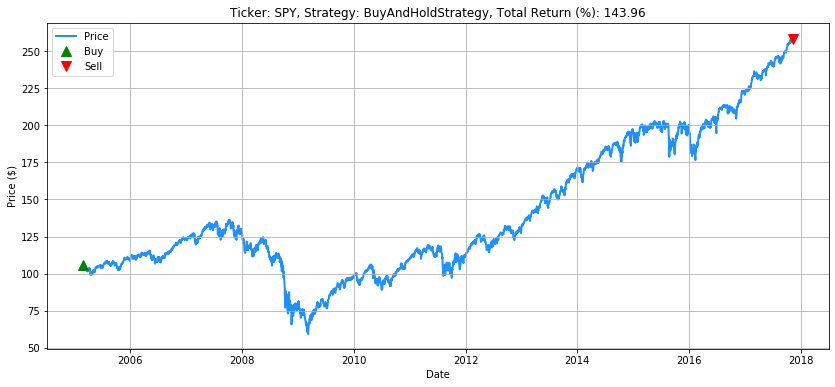

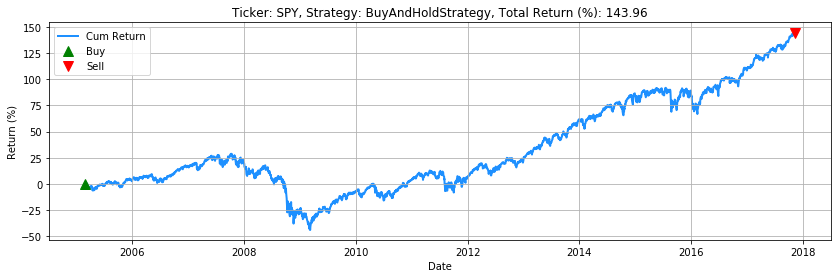

Running strategy: SimpleMovingAvgCrossOverStrategy


,Tearsheet
Ticker,ABC
Strategy,SimpleMovingAvgCrossOverStrategy
Start Date,1995-04-04
End Date,2017-11-10
Total Return (%),1775.20
Yearly Return (%),13.86
Yearly Volatility (%),24.07
Sharpe Ratio,0.661276
Number of Trades,18
Config,"{'sma_short': 100, 'sma_long': 300}"


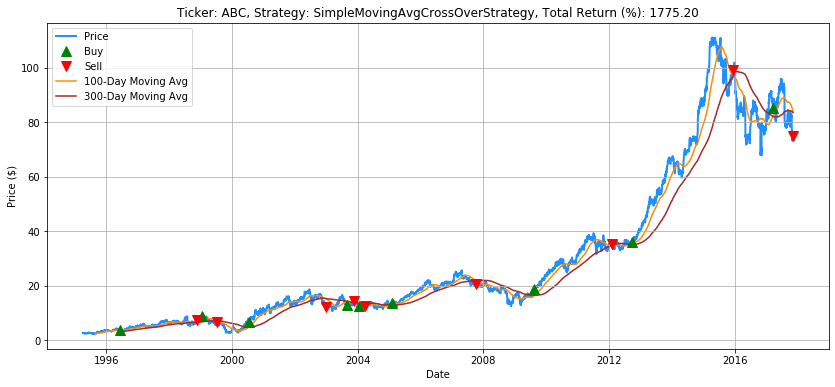

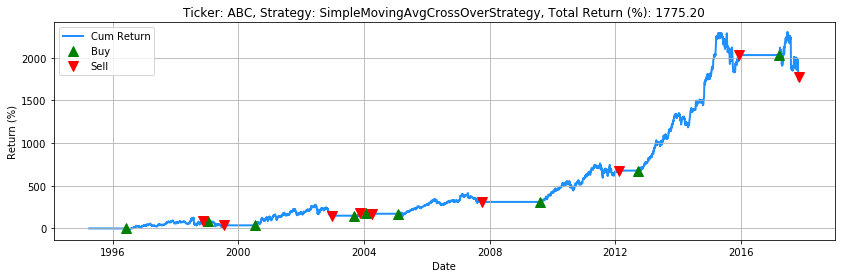

Running strategy: BollingerBandStrategy


,Tearsheet
Ticker,AAPL
Strategy,BollingerBandStrategy
Start Date,1984-09-07
End Date,2017-11-10
Total Return (%),-4.36
Yearly Return (%),-0.13
Yearly Volatility (%),32.09
Sharpe Ratio,0.163911
Number of Trades,164
Config,"{'sma': 20, 'sd': 2}"


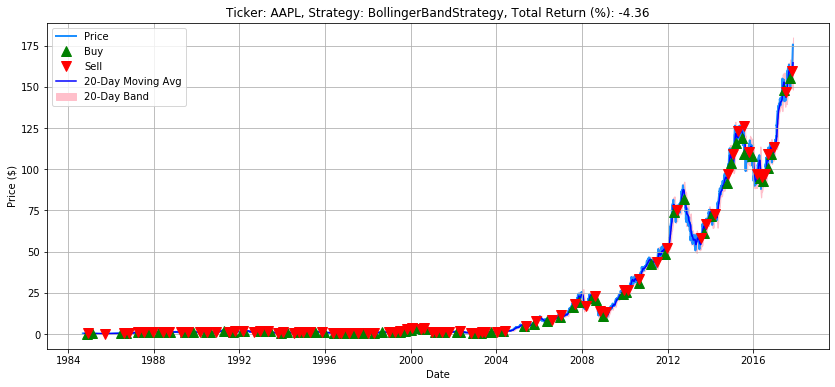

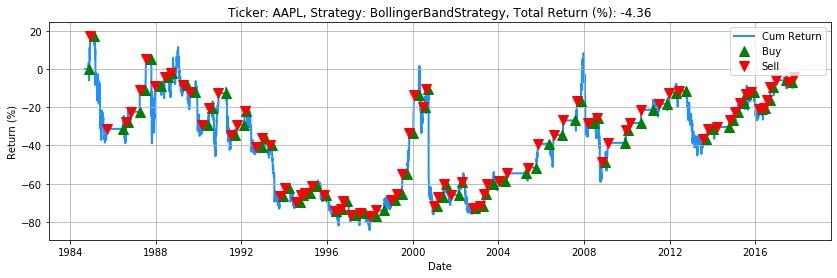

In [11]:
backtest_list = [[BuyAndHoldStrategy, 'SPY'],
                 [SimpleMovingAvgCrossOverStrategy, 'ABC'],
                 [BollingerBandStrategy, 'AAPL']]

for strategy, ticker in backtest_list:
    print('Running strategy: {}'.format(strategy.__name__))
    backtest = Backtest(strategy, ticker)
    backtest.run()
    backtest.tearsheet()

Now that we can run a backtest for a particular strategy and configuration, let's try to search across a number of parameters for the best performaning values (return, Sharpe, etc.). Let's create a backtester capable of running strategies with multiple configurations and some helper functions to generate multiple strategy configurations.

In [12]:
from abc import ABC, abstractmethod


class ConfigSearch(ABC):
    """
    Base class for generating strategy configurations.
    """
    @staticmethod
    @abstractmethod
    def get_count():
        """
        Returns the number of potential strategy configurations that can be generated and executed.
        
        Returns:
            (int): The number of strategy configurations available.
        """
        pass

    @staticmethod
    @abstractmethod
    def get_config(i):
        """
        Returns the i-th strategy configuration.
        
        Args:
            i (int): Specifies which strategy configuration to return.

        Returns:
            (Dict): The specific strategy configuration.
        """
        pass


class BuyAndHoldStrategyConfig(ConfigSearch):
    """
    Specifies strategy configurations for the Buy and Hold Strategy.
    """
    @staticmethod
    def get_count():
        """
        Returns the number of strategy configurations available for the Buy and Hold Strategy.
        
        Returns:
            (int): The number of strategy configurations available.
        """
        return 1

    @staticmethod
    def get_config(i):
        """
        Returns the i-th strategy configuration for the Buy and Hold Strategy.
        
        This function always returns the same trivial configuration.

        Args:
            i (int): Specifies which strategy configuration to return.

        Returns:
            (Dict): The specific strategy configuration.
        """
        return None


class SimpleMovingAvgConfig(ConfigSearch):
    """
    Specifies strategy configurations for the Simple Moving Average Crossover Strategy.
    """

    sma_list = [[5, 50], [10, 100], [25, 200]]

    @classmethod
    def get_count(cls):
        """
        Returns the number of strategy configurations available for the Simple Moving Average Crossover Strategy.
        
        Returns:
            (int): The number of strategy configurations available.
        """
        return len(cls.sma_list)

    @classmethod
    def get_config(cls, i):
        """
        Returns the i-th strategy configuration for the Simple Moving Average Crossover Strategy.
        
        This function always returns the same trivial configuration.

        Args:
            i (int): Specifies which strategy configuration to return.

        Returns:
            (Dict): The specific strategy configuration.
        """
        sma_short, sma_long = cls.sma_list[i]
        config = {}
        config['sma_short'] = sma_short
        config['sma_long'] = sma_long
        return config


class BollingerBandConfig(ConfigSearch):
    """
    Specifies strategy configurations for the Bollinger Band Strategy.
    """
    @staticmethod
    def get_count():
        """
        Return the number of strategy configurations available.
        
        In the case of the Bollinger Band Strategy we randomly generate strategy configurations.

        Returns:
            (int): The number of strategy configurations available.
        """
        return float('inf')

    @staticmethod
    def get_config(i):
        """
        Returns the i-th strategy configuration for the Simple Moving Average Crossover Strategy.
        
        In the case of the Bollinger Band Strategy we are going to randomly generate strategy configurations and
        therefore any arguments to this function are ignored.

        Args:
            i (int): Specifies which strategy configuration to return. This argument is ignored.

        Returns:
            (Dict): The specific strategy configuration.
        """
        config = {}
        config['sma'] = int(2 ** np.random.uniform(2, 4))
        config['sd'] = 2 ** np.random.uniform(0, 1.5)
        return config


class BacktestConfigSearch():
    """
    Runs multiple backtests across a number of possible strategy configurations.
    
    Attributes:
        strategy_cls (Strategy): Strategy class.
        ticker (str): Ticker name.
        config_search (ConfigSearch): Class for generating strategy configurations.
        num_runs (int): Determines the number of runs for a given strategy.
        start_date (str): A start date for backtesting.
        end_date (str): An end date for backtesting.
        results (pd.DataFrame): Stores results for all backtest runs.
    """
    def __init__(self,
                 strategy_cls,
                 ticker,
                 config_search_cls,
                 num_runs=None,
                 start_date=None,
                 end_date=None):
        self.strategy_cls = strategy_cls
        self.ticker = ticker.lower()

        self.config_search = config_search_cls()
        self.num_runs = num_runs

        self.start_date = start_date
        self.end_date = end_date

        self.results = []

    def run(self):
        """
        Runs a number of backtests for a given strategy trying out multiple configurations.

        Returns:
            (pd.DataFrame): The backtest results.
        """
        num_runs = self.config_search.get_count()
        if self.num_runs is not None:
            num_runs = min(num_runs, self.num_runs)

        results = []
        for i in range(num_runs):
            config = self.config_search.get_config(i)
            backtest = Backtest(self.strategy_cls, self.ticker, config,
                                self.start_date, self.end_date)
            stats = backtest.run()
            r = {}
            r['ticker'] = self.ticker
            r['strategy'] = self.strategy_cls.__name__
            r['config'] = config
            r['total_return'] = stats['total_return']
            r['cagr'] = stats['cagr']
            r['volatility'] = stats['volatility']
            r['sharpe'] = stats['sharpe']
            r['num_trades'] = stats['num_trades']
            results.append(r)

        self.results = pd.DataFrame(results)
        return self.results

Let's select a period of 5 years to look for some well-performing tickers and strategies.

In [13]:
start_date = '2010-01-01'
end_date = '2015-12-31'

Next we select a universe of tickers that meet certain criteria (min price, min number of data points, etc.).

In [14]:
def filter_tickers(min_usd_vol=0,
                   min_data_points=0,
                   min_price=0,
                   start_date=None,
                   end_date=None,
                   max_pct_chg=None):
    """
    Filters out tickers based on defined criteria:
    
    Args:
        min_usd_vol (float): Defines the lowest acceptable price
        min_data_points (int): Defines the minimum accceptable number of available data points.
        min_price (float): Defines the minimum acceptable instrument price.
        start_date (float): Defines which start date should be used for loading market data.
        end_date (float): Defines which end date should be used for loading market data.
        max_pct_chg (float): Defines the lowest maximum allowable absolute percent daily change in the price move.
    
    Returns:
        (List[str]): A list of tickers meeting the speficied criteria.
    """

    ticker_list = []
    tickers = equity_data.get_all_tickers()
    for t in tqdm(tickers):
        data = equity_data.get_csv_data(t, start_date, end_date)

        if len(data) < min_data_points:
            continue

        n_last_days = 10
        if np.median(data['price'][-n_last_days:] *
                     data['volume'][-n_last_days:]) < min_usd_vol:
            continue

        if min(data['price']) < min_price:
            continue

        if max_pct_chg is not None and np.max(np.abs(
                data.price.pct_change())) > max_pct_chg:
            continue

        ticker_list.append(t)

    return ticker_list


filtered_tickers = filter_tickers(min_usd_vol=50000000,
                                  min_data_points=2 * 252,
                                  min_price=1,
                                  start_date=start_date,
                                  end_date=end_date,
                                  max_pct_chg=5)

print('Number of filtered tickers: {}'.format(len(filtered_tickers)))


Number of filtered tickers: 684


Now that we defined a universe of appropriate stocks, let's search for best parameters for each ticker and strategy.

In [15]:
search_grid = [[BuyAndHoldStrategy, BuyAndHoldStrategyConfig, None],
               [SimpleMovingAvgCrossOverStrategy, SimpleMovingAvgConfig, None],
               [BollingerBandStrategy, BollingerBandConfig, 3]]

results = []
for ticker in tqdm(filtered_tickers):
    for strategy, config, num_runs in search_grid:
        backtest_search = BacktestConfigSearch(strategy, ticker, config,
                                               num_runs, start_date, end_date)
        results.append(backtest_search.run())

results = pd.concat(results).reset_index()
print("There are {} results generated".format(len(results)))


There are 4788 results generated


Let's only select the best performing (based on Sharpe Ratio) parameters for each ticker and strategy.

In [16]:
r = results.groupby([
    'ticker', 'strategy'
])['sharpe'].max().reset_index().rename(columns={'sharpe': 'max_sharpe'})
results = results.merge(r, how='left', on=['ticker', 'strategy'])
results.head()
results = results[results['sharpe'] == results['max_sharpe']]
results.head()

,index,ticker,strategy,config,total_return,cagr,volatility,sharpe,num_trades,max_sharpe
0,0,a,BuyAndHoldStrategy,None,0.944292,0.117354,0.307179,0.515564,2,0.515564
2,1,a,SimpleMovingAvgCrossOverStrategy,"{'sma_short': 10, 'sma_long': 100}",0.670163,0.089371,0.186892,0.551693,28,0.551693
6,2,a,BollingerBandStrategy,"{'sma': 11, 'sd': 1.3276629202068315}",1.084548,0.130418,0.232761,0.643671,94,0.643671
7,0,aa,BuyAndHoldStrategy,None,-0.375151,-0.075478,0.341810,-0.058511,2,-0.058511
10,2,aa,SimpleMovingAvgCrossOverStrategy,"{'sma_short': 25, 'sma_long': 200}",0.726896,0.095461,0.183483,0.588939,8,0.588939


Let's plot all the results on one chart:

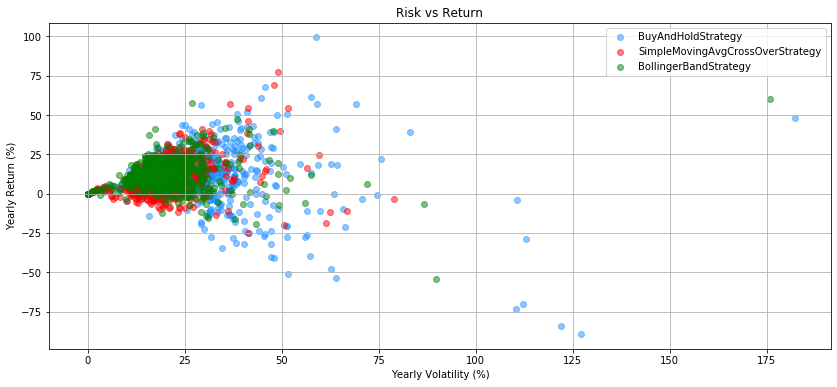

In [17]:
fig = plt.figure(figsize=(14, 6))
plt.title('Risk vs Return')

colors = {
    'BuyAndHoldStrategy': 'dodgerblue',
    'SimpleMovingAvgCrossOverStrategy': 'red',
    'BollingerBandStrategy': 'green',
}

for s in colors:
    r = results[(results['strategy'] == s)]
    plt.scatter(100 * r['volatility'],
                100 * r['cagr'],
                color=colors[s],
                label=s,
                alpha=0.5)

plt.xlabel('Yearly Volatility (%)')
plt.ylabel('Yearly Return (%)')
plt.legend()
plt.grid()
plt.show()

This chart looks quite busy. Overall the Buy and Hold Strategy seems to imply the highest amount of risk. Also the Bollinger Band Strategy results seem to have a better performance compared to the Simple Moving Average Cross Over Strategy -- for the same level of risk, it looks the return is higher for the former.

Let's zoom in by limiting yearly returns and volatility to less than 50%.

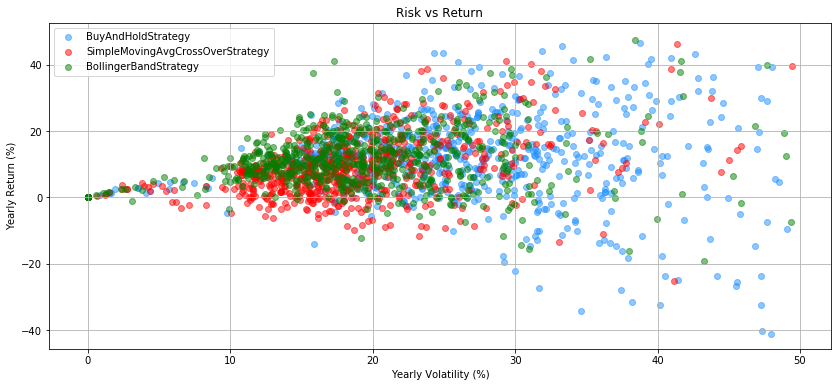

In [18]:
fig = plt.figure(figsize=(14, 6))
plt.title('Risk vs Return')

colors = {
    'BuyAndHoldStrategy': 'dodgerblue',
    'SimpleMovingAvgCrossOverStrategy': 'red',
    'BollingerBandStrategy': 'green',
}

for s in colors:
    r = results[(results['strategy'] == s) & (results['cagr'] < 0.5) &
                (results['volatility'] < 0.5)]
    plt.scatter(100 * r['volatility'],
                100 * r['cagr'],
                color=colors[s],
                label=s,
                alpha=0.5)

plt.xlabel('Yearly Volatility (%)')
plt.ylabel('Yearly Return (%)')
plt.legend()
plt.grid()
plt.show()

Again, we see that on average the Bollinger Band strategy seem to give us a higher level of return for the same amount of risk.

Let's compare histograms of Sharpe Ratios and Yearly Returns across the three strategies.

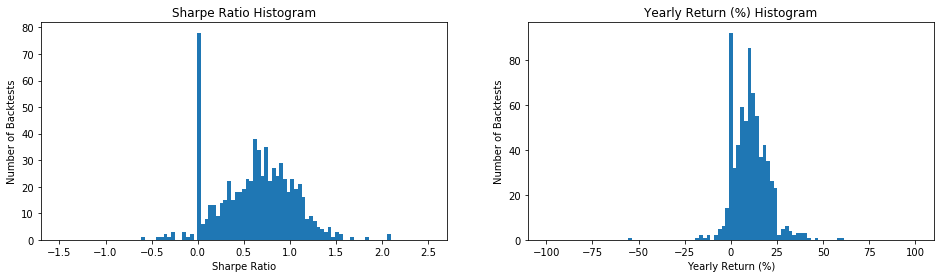

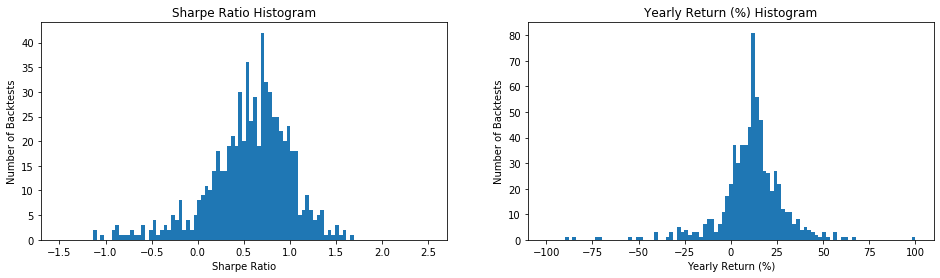

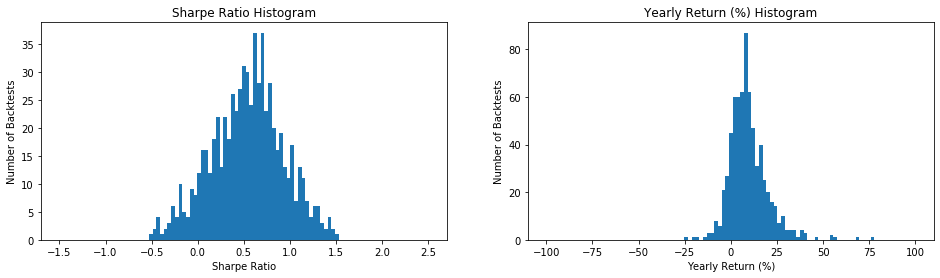

In [19]:
for s in np.unique(results['strategy']):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
    display(HTML('<center><h3>{}</h3></center>'.format(s)))
    ax1.set_title('Sharpe Ratio Histogram')
    ax1.hist(results[results['strategy'] == s]['sharpe'],
             bins=np.linspace(-1.5, 2.5, 100))
    ax1.set_xlabel('Sharpe Ratio')
    ax1.set_ylabel('Number of Backtests')

    ax2.set_title('Yearly Return (%) Histogram')
    ax2.hist(100 * results[results['strategy'] == s]['cagr'],
             bins=np.linspace(-100, 100, 100))
    ax2.set_xlabel('Yearly Return (%)')
    ax2.set_ylabel('Number of Backtests')

    plt.show()

It looks like (based on the Sharpe Ratio histograms) the Bollinger Band strategy has a better performance than the Simple Moving Average Cross Over strategy. The results for the Bollinger Band strategy are comparable to the Buy and Hold strategy -- Sharpe Ratio histograms are simmilar, but the former has more concentrated Yearly Return results.

Let's look at how many trades each strategy executed.

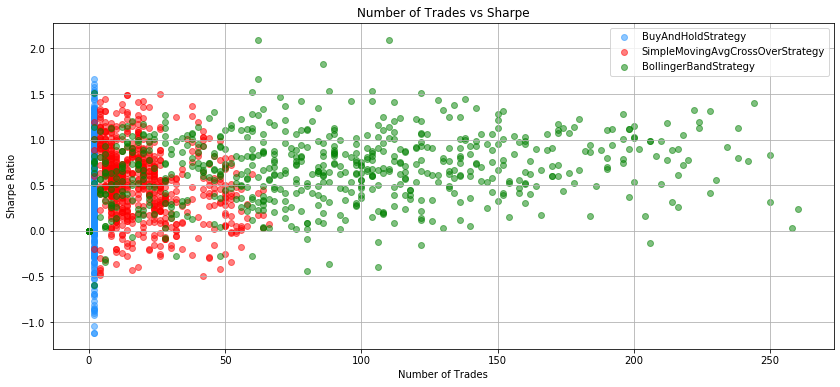

In [20]:
fig = plt.figure(figsize=(14, 6))
plt.title('Number of Trades vs Sharpe')

colors = {
    'BuyAndHoldStrategy': 'dodgerblue',
    'SimpleMovingAvgCrossOverStrategy': 'red',
    'BollingerBandStrategy': 'green',
}

for s in colors:
    r = results[results['strategy'] == s]
    plt.scatter(r['num_trades'],
                r['sharpe'],
                color=colors[s],
                label=s,
                alpha=0.5)

plt.xlabel('Number of Trades')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.grid()
plt.show()

Please note that the Buy and Hold strategy always executes exactly twice per ticker.

Clearly the Bollinger Band strategy executed more trades -- this would definitely have an impact of strategy performance if we take into account trading costs (which we're ignoring as part of our analysis here).

Let's see which strategy turned out to best across all three strategies.

In [21]:
r = results.groupby([
    'ticker'
])['sharpe'].max().reset_index().rename(columns={'sharpe': 'max_sharpe_ticker'})
r2 = results.merge(r, how='left', on=['ticker'])
r3 = r2[r2['sharpe'] == r2['max_sharpe_ticker']]

r4 = r3.groupby('ticker')[['strategy']].first().reset_index()
cnt_strategy = r4.groupby('strategy')['ticker'].count().reset_index().rename(columns={'ticker': 'count'})
cnt_strategy.sort_values(by='count', ascending=False)

,strategy,count
0,BollingerBandStrategy,370
2,SimpleMovingAvgCrossOverStrategy,162
1,BuyAndHoldStrategy,152


It looks like the Bollinger Band strategy comes out on top -- it most frequently outperforms the Simple Moving Average Cross Over and Buy and Hold strategies.

## Bollinger Band Strategy

Top performers for this strategy are:

In [22]:
r = results[results['strategy'] == 'BollingerBandStrategy'].sort_values(
    by='sharpe', ascending=False)
r.head()

,index,ticker,strategy,config,total_return,cagr,volatility,sharpe,num_trades,max_sharpe
4379,0,vntv,BollingerBandStrategy,"{'sma': 5, 'sd': 1.2818928940993792}",2.313482,0.373622,0.157907,2.091986,110,2.091986
1167,1,dlph,BollingerBandStrategy,"{'sma': 8, 'sd': 1.6424711877838276}",3.122303,0.412271,0.172791,2.087233,62,2.087233
3022,1,now,BollingerBandStrategy,"{'sma': 7, 'sd': 1.141620252049483}",3.922920,0.576805,0.268245,1.833127,86,1.833127
187,1,agn,BollingerBandStrategy,"{'sma': 9, 'sd': 1.8056914261842962}",4.204523,0.316907,0.174662,1.664759,62,1.664759
2043,2,hrl,BollingerBandStrategy,"{'sma': 10, 'sd': 1.449033613532079}",1.688876,0.179607,0.111562,1.537832,88,1.537832


Here is a tearsheet for the top result:

,Tearsheet
Ticker,VNTV
Strategy,BollingerBandStrategy
Start Date,2012-03-22
End Date,2015-12-31
Total Return (%),231.35
Yearly Return (%),37.36
Yearly Volatility (%),15.79
Sharpe Ratio,2.09199
Number of Trades,110
Config,"{'sma': 5, 'sd': 1.2818928940993792}"


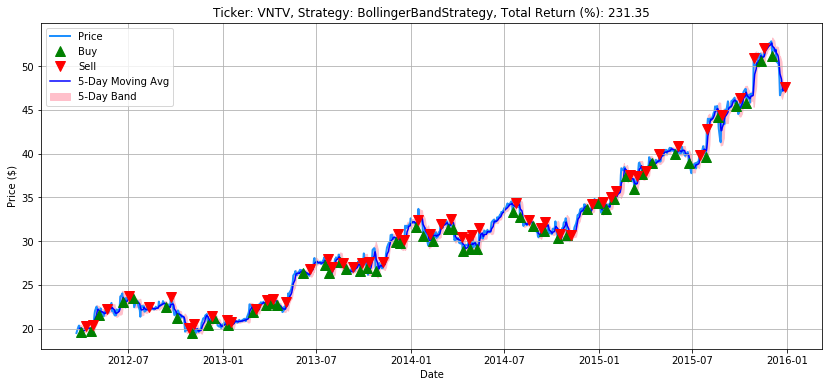

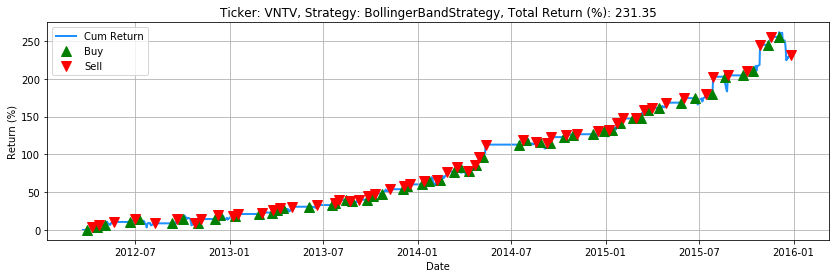

In [23]:
backtest = Backtest(eval(r.iloc[0]['strategy']), r.iloc[0]['ticker'],
                    r.iloc[0]['config'], start_date, end_date)
backtest.run()
backtest.tearsheet()

Let's see how different parameters affect performance.

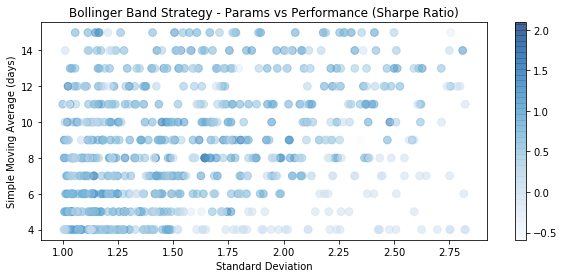

In [24]:
fig, ax = plt.subplots(figsize=(10, 4))

sd = [c['sd'] for c in r['config']]
sma = [c['sma'] for c in r['config']]
sharpe = [s for s in r['sharpe']]
im = ax.scatter(sd, sma, c=sharpe, cmap='Blues', alpha=0.5, s=60)
fig.colorbar(im)
plt.title('Bollinger Band Strategy - Params vs Performance (Sharpe Ratio)')
plt.xlabel('Standard Deviation')
plt.ylabel('Simple Moving Average (days)')
plt.show()

For strategies where SMA is between 4 and 8, the performance seems to be better when Standard Deviation <= 2. But otherwise there does not seem to be a clear pattern for best performing parameters.

## Simple Moving Average CrossOver Strategy

Top performers for this strategy are:

In [25]:
r = results[results['strategy'] ==
            'SimpleMovingAvgCrossOverStrategy'].sort_values(by='sharpe',
                                                            ascending=False)
r.head()

,index,ticker,strategy,config,total_return,cagr,volatility,sharpe,num_trades,max_sharpe
2633,0,lyb,SimpleMovingAvgCrossOverStrategy,"{'sma_short': 5, 'sma_long': 50}",5.282167,0.382126,0.234237,1.500364,26,1.500364
1206,1,dpz,SimpleMovingAvgCrossOverStrategy,"{'sma_short': 10, 'sma_long': 100}",6.045467,0.385477,0.238422,1.487079,14,1.487079
3662,0,sjnk,SimpleMovingAvgCrossOverStrategy,"{'sma_short': 5, 'sma_long': 50}",0.142454,0.035844,0.023939,1.484709,14,1.484709
1592,2,exr,SimpleMovingAvgCrossOverStrategy,"{'sma_short': 25, 'sma_long': 200}",4.157972,0.315172,0.203946,1.446805,6,1.446805
2809,1,mo,SimpleMovingAvgCrossOverStrategy,"{'sma_short': 10, 'sma_long': 100}",1.835935,0.190006,0.128243,1.422095,20,1.422095


,Tearsheet
Ticker,LYB
Strategy,SimpleMovingAvgCrossOverStrategy
Start Date,2010-04-28
End Date,2015-12-31
Total Return (%),528.22
Yearly Return (%),38.21
Yearly Volatility (%),23.42
Sharpe Ratio,1.50036
Number of Trades,26
Config,"{'sma_short': 5, 'sma_long': 50}"


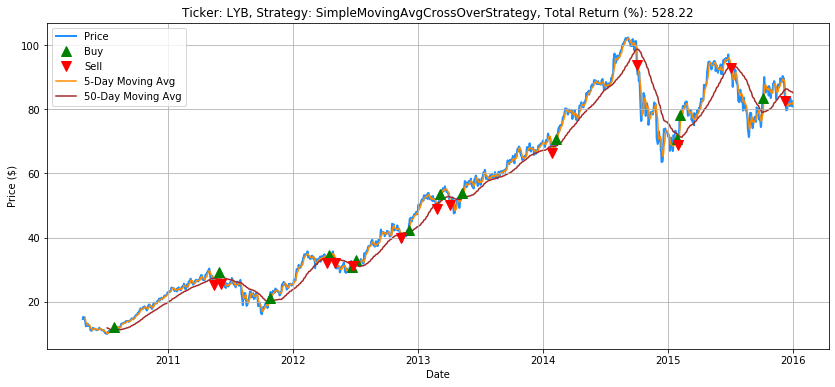

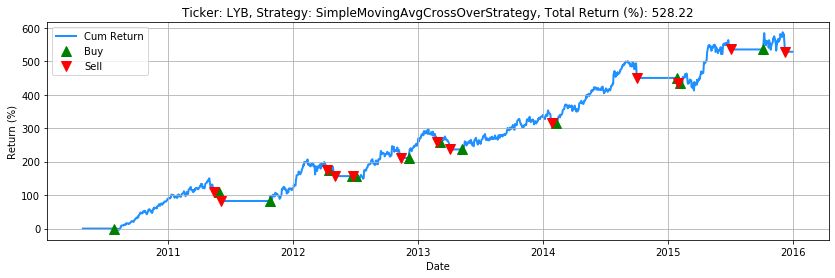

In [26]:
backtest = Backtest(eval(r.iloc[0]['strategy']), r.iloc[0]['ticker'],
                    r.iloc[0]['config'], start_date, end_date)
backtest.run()
backtest.tearsheet()

Let's plot a histogram strategy performance for each tested configuration.

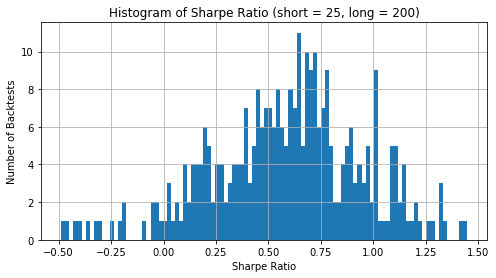

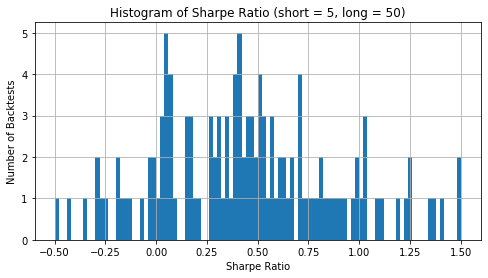

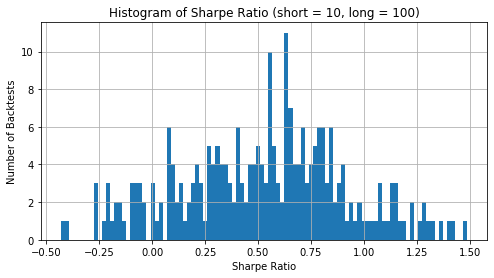

In [27]:
r = results[results['strategy'] == 'SimpleMovingAvgCrossOverStrategy'].copy()

for sma_short, sma_long in set(tuple(x.values()) for x in r['config']):
    plt.figure(figsize=(8, 4))
    plt.title('Histogram of Sharpe Ratio (short = {}, long = {})'.format(
        sma_short, sma_long))
    plt.hist(r[r['config'] == {
        'sma_short': sma_short,
        'sma_long': sma_long
    }]['sharpe'],
             bins=100)
    plt.xlabel('Sharpe Ratio')
    plt.ylabel('Number of Backtests')
    plt.grid()
    plt.show()

It looks like the 20/200 SMA Cross Over strategy has the best results on average.

## Conclusion

In general we saw that the Bollinger Bands strategy performs the best for a number of tickers given the time window we selected. But each strategy has its pros and cons. The number of trades that are executed as part of the Bollinger Band strategy is much higher compared to the other two -- this would definitely have an impact if we considered trading costs.

There are a lot more steps we could take to compare these strategies. Firstly we could select a validation test (using data from 2016 onwards and compare results). We could also relax our ticker filtering process and allow for more tickers to be evaluated. Also, we could calculate a lot more statistics (max drawdown, etc.).

For now we end our analysis here.